In [1]:
import xarray as xr
import os
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import dask.dataframe as dd


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Prepare data

In [ ]:
base_dir = Path.cwd()
start_folder = "2020-08"
end_folder = "2025-01"

file_paths = []
for folder in sorted(base_dir.iterdir()):
    if folder.is_dir() and start_folder <= folder.name <= end_folder:
        nc_files = sorted(folder.glob("*.nc"))
        file_paths.extend(nc_files[::10])  

if not file_paths:
    raise ValueError("No .nc files found in the specified range.")

print(f"Selected {len(file_paths)} files for concatenation.")

batch_size = 34
batch_files = []
intermediate_files = []

for batch_idx, i in enumerate(range(0, len(file_paths), batch_size), start=1):
    batch_files = file_paths[i:i + batch_size]
    print(f"\nProcessing batch {batch_idx} with {len(batch_files)} files...")
    successful_files = 0 

    try:
        combined_ds = None
        for file_idx, file in enumerate(batch_files, start=1):
            try:
                current_ds = xr.open_dataset(file)
                if combined_ds is None:
                    combined_ds = current_ds
                else:
                    combined_ds = xr.concat([combined_ds, current_ds], dim="time")
                
                successful_files += 1
                print(f"{successful_files} files combined in batch {batch_idx}...")
            except Exception as e:
                print(f"Failed to process file: {file}. Error: {e}")

        if combined_ds is not None:
            intermediate_file = base_dir / f"intermediate_batch_{batch_idx}.nc"
            combined_ds.to_netcdf(intermediate_file)
            intermediate_files.append(intermediate_file)
            print(f"Batch {batch_idx} saved to: {intermediate_file}")
        else:
            print(f"No files successfully processed in batch {batch_idx}.")
    except Exception as e:
        print(f"Failed to process batch {batch_idx}: {e}")

if intermediate_files:
    print(f"\nCombining {len(intermediate_files)} intermediate files into a final dataset...")
    final_ds = xr.open_mfdataset(intermediate_files, combine="by_coords", parallel=True)
    final_output_file = base_dir / "final_concatenated_output.nc"
    final_ds.to_netcdf(final_output_file)
    print(f"Final concatenated dataset saved to: {final_output_file}")
else:
    print("No intermediate files were created. Nothing to combine.")



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Selected 334 files for concatenation.

Processing batch 1 with 34 files...
1 files combined in batch 1...
2 files combined in batch 1...
3 files combined in batch 1...
4 files combined in batch 1...
5 files combined in batch 1...
6 files combined in batch 1...
7 files combined in batch 1...
8 files combined in batch 1...
9 files combined in batch 1...
10 files combined in batch 1...
11 files combined in batch 1...
12 files combined in batch 1...
13 files combined in batch 1...
14 files combined 

# Concat all using DASK

In [2]:
def concat_nc_files_with_dask(file_paths, output_file):
    try:
        print(f"Starting concatenation of {len(file_paths)} files using Dask...")
        combined_dataset = None
        successful_count = 0

        for i, file in enumerate(file_paths, start=1):
            print(f"Processing file {i} of {len(file_paths)}: {file.name}")
            
            # Open the current NetCDF file with Dask
            current_ds = xr.open_dataset(file, chunks={"time": 100})
            
            # Concatenate incrementally
            if combined_dataset is None:
                combined_dataset = current_ds
            else:
                combined_dataset = xr.concat([combined_dataset, current_ds], dim="time", 
                                             data_vars="minimal", coords="minimal", compat="override")
            
            successful_count += 1
            print(f"{successful_count} files concatenated successfully so far.")

        # Save the combined dataset using Dask
        print(f"Saving the final concatenated dataset to: {output_file}")
        combined_dataset.to_netcdf(output_file, compute=True)
        print("Final concatenated dataset saved successfully.")
    
    except Exception as e:
        print(f"Failed during concatenation: {e}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
base_dir = Path.cwd()
file_paths = sorted(base_dir.glob("intermediate_batch_*.nc"))  
output_file = base_dir / "final_combined_output.nc"  

concat_nc_files_with_dask(file_paths, output_file)


Starting concatenation of 9 files using Dask...
Processing file 1 of 9: intermediate_batch_10.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


1 files concatenated successfully so far.
Processing file 2 of 9: intermediate_batch_2.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


2 files concatenated successfully so far.
Processing file 3 of 9: intermediate_batch_3.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


3 files concatenated successfully so far.
Processing file 4 of 9: intermediate_batch_4.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


4 files concatenated successfully so far.
Processing file 5 of 9: intermediate_batch_5.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


5 files concatenated successfully so far.
Processing file 6 of 9: intermediate_batch_6.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


6 files concatenated successfully so far.
Processing file 7 of 9: intermediate_batch_7.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


7 files concatenated successfully so far.
Processing file 8 of 9: intermediate_batch_8.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


8 files concatenated successfully so far.
Processing file 9 of 9: intermediate_batch_9.nc


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


9 files concatenated successfully so far.
Saving the final concatenated dataset to: /Volumes/Shentong Li/DSC180-Weather data/weather data/final_combined_output.nc
Final concatenated dataset saved successfully.


# Do Analysis directly on NC file

In [3]:
final_combined_file = Path.cwd() / "final_combined_output.nc"


ds = xr.open_dataset(final_combined_file, chunks={"time": 1000}) 



/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
mean_temperature = ds["air_temperature_2m"].mean(dim="time").compute()
print("Mean Temperature:")
mean_temperature


Mean Temperature:


<xarray.DataArray 'air_temperature_2m' (y: 134, x: 170)> Size: 91kB
array([[58.676704, 58.695927, 58.717297, ..., 71.04763 , 70.761406,
        70.85555 ],
       [58.66937 , 58.687668, 58.70837 , ..., 71.186   , 70.94737 ,
        70.88874 ],
       [58.662037, 58.68159 , 58.698483, ..., 70.87081 , 71.476814,
        70.87822 ],
       ...,
       [63.872593, 60.537556, 60.351665, ..., 69.7343  , 69.15604 ,
        68.45952 ],
       [59.673298, 59.93974 , 60.286407, ..., 69.35207 , 69.00522 ,
        68.44537 ],
       [59.09626 , 59.279   , 59.063667, ..., 69.092445, 68.81433 ,
        68.42315 ]], dtype=float32)
Coordinates:
    latitude   (y, x) float32 91kB 32.14 32.14 32.14 32.14 ... 34.42 34.42 34.42
    longitude  (y, x) float32 91kB -118.7 -118.7 -118.7 ... -115.0 -115.0 -115.0
Dimensions without coordinates: y, x

In [4]:
temp_df = mean_temperature.to_dataframe(name="air_temperature_2m").reset_index()
temp_df

,y,x,latitude,longitude,air_temperature_2m
0,0,0,32.141769,-118.695343,58.676704
1,0,1,32.141438,-118.674118,58.695927
2,0,2,32.141094,-118.652893,58.717297
3,0,3,32.140747,-118.631668,58.737335
4,0,4,32.140400,-118.610443,58.758480
...,...,...,...,...,...
22775,133,165,34.422878,-115.038284,68.846779
22776,133,166,34.421867,-115.016479,68.947594
22777,133,167,34.420845,-114.994690,69.092445
22778,133,168,34.419823,-114.972885,68.814331


In [5]:
# max wind gust over time
max_wind_gust = ds["surface_wind_gust"].max(dim="time").compute()
print("Max Wind Gust:")
max_wind_gust

Max Wind Gust:


<xarray.DataArray 'surface_wind_gust' (y: 134, x: 170)> Size: 91kB
array([[48., 49., 50., ..., 54., 53., 57.],
       [48., 49., 50., ..., 54., 52., 54.],
       [48., 49., 49., ..., 52., 55., 54.],
       ...,
       [61., 55., 53., ..., 51., 50., 49.],
       [63., 53., 54., ..., 52., 50., 47.],
       [64., 57., 52., ..., 53., 49., 46.]], dtype=float32)
Coordinates:
    latitude   (y, x) float32 91kB 32.14 32.14 32.14 32.14 ... 34.42 34.42 34.42
    longitude  (y, x) float32 91kB -118.7 -118.7 -118.7 ... -115.0 -115.0 -115.0
Dimensions without coordinates: y, x

In [6]:
wind_df = max_wind_gust.to_dataframe(name="surface_wind_gust").reset_index()
wind_df

,y,x,latitude,longitude,surface_wind_gust
0,0,0,32.141769,-118.695343,48.0
1,0,1,32.141438,-118.674118,49.0
2,0,2,32.141094,-118.652893,50.0
3,0,3,32.140747,-118.631668,50.0
4,0,4,32.140400,-118.610443,49.0
...,...,...,...,...,...
22775,133,165,34.422878,-115.038284,65.0
22776,133,166,34.421867,-115.016479,57.0
22777,133,167,34.420845,-114.994690,53.0
22778,133,168,34.419823,-114.972885,49.0


In [ ]:
# humidity
mean_humidity = ds["relative_humidity_2m"].mean(dim=["y", "x"]).compute()
print("Mean Humidity Over Time:")
mean_humidity


Mean Humidity Over Time:


<xarray.DataArray 'relative_humidity_2m' (time: 27000)> Size: 108kB
array([41.5198  , 42.788498, 43.988674, ..., 36.10992 , 35.574627,
       35.584766], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 216kB 2024-09-06T07:00:00 ... 2024-09-05

In [ ]:
# precipitation
total_precip = ds["accumulated_precipitation_amount"].sum(dim="time").compute()
print("Total Precipitation Per Location:")
total_precip

Total Precipitation Per Location:


<xarray.DataArray 'accumulated_precipitation_amount' (y: 134, x: 170)> Size: 91kB
array([[ 511.70312,  513.1875 ,  525.     , ...,  179.89844,  180.74219,
         181.78906],
       [ 503.16406,  503.4922 ,  506.72656, ...,  176.92188,  172.64062,
         173.52344],
       [ 500.6328 ,  496.70312,  500.92188, ...,  164.78125,  160.65625,
         167.47656],
       ...,
       [1337.6016 , 1295.7734 , 1271.7422 , ...,  630.96094,  613.7422 ,
         636.4453 ],
       [1380.0703 , 1345.5234 , 1326.5469 , ...,  697.9219 ,  638.875  ,
         620.16406],
       [1430.7266 , 1399.875  , 1370.6797 , ...,  721.90625,  669.75   ,
         628.5547 ]], dtype=float32)
Coordinates:
    latitude   (y, x) float32 91kB 32.14 32.14 32.14 32.14 ... 34.42 34.42 34.42
    longitude  (y, x) float32 91kB -118.7 -118.7 -118.7 ... -115.0 -115.0 -115.0
Dimensions without coordinates: y, x

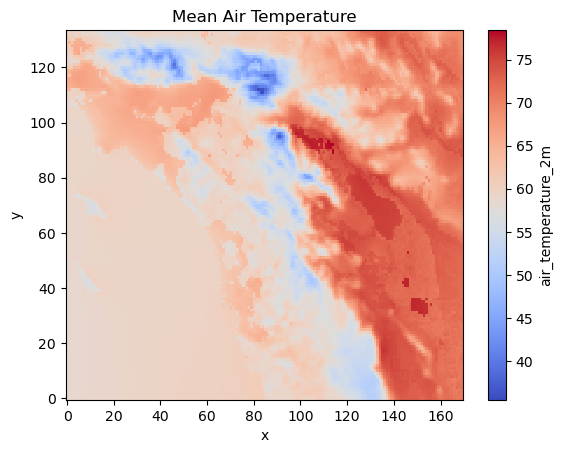

In [21]:
ds["air_temperature_2m"].mean(dim="time").plot(cmap="coolwarm")
plt.title("Mean Air Temperature")
plt.show()

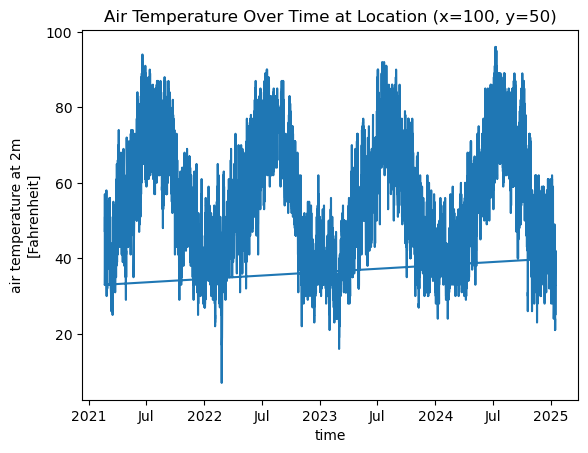

In [22]:
ds["air_temperature_2m"].isel(x=100, y=50).plot()
plt.title("Air Temperature Over Time at Location (x=100, y=50)")
plt.show()

# Trial code

In [2]:
import xarray as xr
import pandas as pd
from pathlib import Path

# Path to the folder containing the NetCDF files
folder_path = Path.cwd() / "2025-01"

# Get a list of NetCDF files in the folder
nc_files = sorted(folder_path.glob("*.nc"))

# Check if there are at least two files
if len(nc_files) < 2:
    raise ValueError("Not enough files in the folder to concatenate.")

# Select the first two files
file1 = nc_files[0]
file2 = nc_files[1]

# Open the files separately and sort by time to ensure monotonicity
ds1 = xr.open_dataset(file1).sortby("time")
ds2 = xr.open_dataset(file2).sortby("time")

# Concatenate the two datasets along the time dimension
ds = xr.concat([ds1, ds2], dim="time")

# Convert the dataset to a DataFrame
df = ds.to_dataframe().reset_index()

# Save the DataFrame to a CSV file for inspection (optional)
output_csv = folder_path / "concatenated_output.csv"
df.to_csv(output_csv, index=False)

print(f"Concatenated dataset converted to DataFrame and saved to: {output_csv}")

# Display the first few rows of the DataFrame
print(df.head())



Concatenated dataset converted to DataFrame and saved to: /Volumes/Shentong Li/DSC180-Weather data/weather data/2025-01/concatenated_output.csv
                 time  y  x  eastward_10m_wind  northward_10m_wind  \
0 2025-01-01 07:00:00  0  0                0.0                -6.0   
1 2025-01-01 07:00:00  0  1                0.0                -5.0   
2 2025-01-01 07:00:00  0  2                0.0                -5.0   
3 2025-01-01 07:00:00  0  3                0.0                -5.0   
4 2025-01-01 07:00:00  0  4                0.0                -5.0   

   eastward_50m_wind  northward_50m_wind  eastward_925mb_wind  \
0                0.0                -6.0                 -2.0   
1                0.0                -6.0                 -2.0   
2                0.0                -6.0                 -2.0   
3                0.0                -6.0                 -2.0   
4                0.0                -6.0                 -2.0   

   northward_925mb_wind  eastward_850mb_wind

In [4]:
df.columns

Index(['time', 'y', 'x', 'eastward_10m_wind', 'northward_10m_wind',
       'eastward_50m_wind', 'northward_50m_wind', 'eastward_925mb_wind',
       'northward_925mb_wind', 'eastward_850mb_wind', 'northward_850mb_wind',
       'eastward_700mb_wind', 'northward_700mb_wind', 'eastward_500mb_wind',
       'northward_500mb_wind', 'air_temperature_2m', 'dewpoint_depression_2m',
       'large_fire_potential_weather', 'sea_level_pressure',
       'relative_humidity_2m', 'relative_humidity_pbl',
       'relative_humidity_low_trop', 'relative_humidity_mid_trop',
       'total_precipitable_water', 'air_temperature_925mb',
       'air_temperature_850mb', 'air_temperature_700mb',
       'air_temperature_500mb', 'dew_point_temperature', 'low_cloud_fraction',
       'mid_cloud_fraction', 'high_cloud_fraction', 'cape_lifted_at_surface',
       'cape_max_lifted_between_700mb_500mb', 'mucape',
       'lifted_index_from_surface', 'lifted_index_from_850mb',
       'lifted_index_from_700mb', 'lifted_index_

In [8]:
df.describe()


,time,y,x,eastward_10m_wind,northward_10m_wind,eastward_50m_wind,northward_50m_wind,eastward_925mb_wind,northward_925mb_wind,eastward_850mb_wind,...,hourly_snow_depth,total_totals,surface_wind_gust_max,air_temperature_2m_max,air_temperature_2m_min,surface_divergence,tstorm_potential,crs,latitude,longitude
count,4100400,4.100400e+06,4.100400e+06,4.100400e+06,4.100400e+06,4.100400e+06,4.100400e+06,3.180449e+06,3.180449e+06,3.924941e+06,...,4100400.0,3.924930e+06,4.100400e+06,4.100400e+06,4.100400e+06,4.100400e+06,4.100389e+06,4.100400e+06,4.100400e+06,4.100400e+06
mean,2025-01-03 09:29:59.999999488,6.650000e+01,8.450000e+01,1.011870e+00,-1.234771e+00,1.190591e+00,-1.646940e+00,-4.496189e-02,-1.027720e+00,1.351672e+00,...,0.0,2.317862e+01,1.530518e+01,6.447778e+01,4.208605e+01,2.132863e-02,6.431097e-03,-2.147484e+09,3.329021e+01,-1.168496e+02
min,2025-01-01 07:00:00,0.000000e+00,0.000000e+00,-2.600000e+01,-2.900000e+01,-3.500000e+01,-3.800000e+01,-4.100000e+01,-4.100000e+01,-3.400000e+01,...,0.0,-4.600000e+01,0.000000e+00,1.900000e+01,1.100000e+01,-4.695078e+02,0.000000e+00,-2.147484e+09,3.202923e+01,-1.186953e+02
25%,2025-01-02 11:00:00,3.300000e+01,4.200000e+01,-1.000000e+00,-3.000000e+00,-1.000000e+00,-5.000000e+00,-3.000000e+00,-5.000000e+00,-5.000000e+00,...,0.0,2.100000e+01,1.000000e+01,5.800000e+01,3.700000e+01,-9.820312e+00,0.000000e+00,-2.147484e+09,3.268795e+01,-1.177642e+02
50%,2025-01-03 09:30:00,6.650000e+01,8.450000e+01,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,2.500000e+01,1.300000e+01,6.400000e+01,4.200000e+01,1.226562e+00,0.000000e+00,-2.147484e+09,3.328990e+01,-1.168495e+02
75%,2025-01-04 08:00:00,1.000000e+02,1.270000e+02,3.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,...,0.0,2.700000e+01,1.900000e+01,7.200000e+01,4.700000e+01,1.189062e+01,0.000000e+00,-2.147484e+09,3.389268e+01,-1.159354e+02
max,2025-01-05 12:00:00,1.330000e+02,1.690000e+02,3.900000e+01,3.700000e+01,5.400000e+01,4.800000e+01,4.900000e+01,4.100000e+01,4.800000e+01,...,0.0,3.800000e+01,6.900000e+01,8.400000e+01,7.300000e+01,4.162656e+02,1.800000e+01,-2.147484e+09,3.453493e+01,-1.149511e+02
std,NaN,3.868140e+01,4.907393e+01,4.750282e+00,4.250482e+00,6.890328e+00,6.198460e+00,6.854095e+00,7.188874e+00,8.760774e+00,...,0.0,6.181221e+00,7.939499e+00,8.310270e+00,8.006301e+00,3.447387e+01,1.553571e-01,0.000000e+00,1.041953e+00,3.655775e+00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100400 entries, 0 to 4100399
Data columns (total 61 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   time                                 datetime64[ns]
 1   y                                    int64         
 2   x                                    int64         
 3   eastward_10m_wind                    float32       
 4   northward_10m_wind                   float32       
 5   eastward_50m_wind                    float32       
 6   northward_50m_wind                   float32       
 7   eastward_925mb_wind                  float32       
 8   northward_925mb_wind                 float32       
 9   eastward_850mb_wind                  float32       
 10  northward_850mb_wind                 float32       
 11  eastward_700mb_wind                  float32       
 12  northward_700mb_wind                 float32       
 13  eastward_500mb_wind        

In [10]:
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values[missing_values > 0])

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

Missing Values per Column:
eastward_925mb_wind             919951
northward_925mb_wind            919951
eastward_850mb_wind             175459
northward_850mb_wind            175459
eastward_700mb_wind                248
northward_700mb_wind               248
eastward_500mb_wind                 11
northward_500mb_wind                11
relative_humidity_pbl           175452
relative_humidity_low_trop         224
air_temperature_925mb           919951
air_temperature_850mb           175459
air_temperature_700mb              248
air_temperature_500mb               11
lifted_index_from_surface           11
lifted_index_from_850mb         175470
lifted_index_from_700mb            259
lifted_index_from_650mb             17
geopotential_height_at_850mb    175459
geopotential_height_at_700mb       248
geopotential_height_at_500mb        11
total_totals                    175470
tstorm_potential                    11
dtype: int64
Unique values in latitude_longitude: [b'']


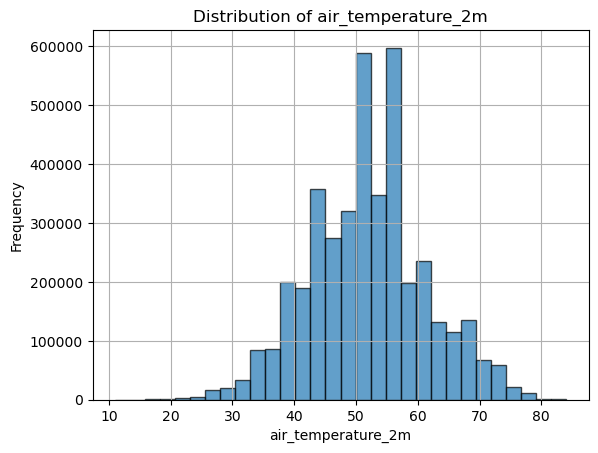

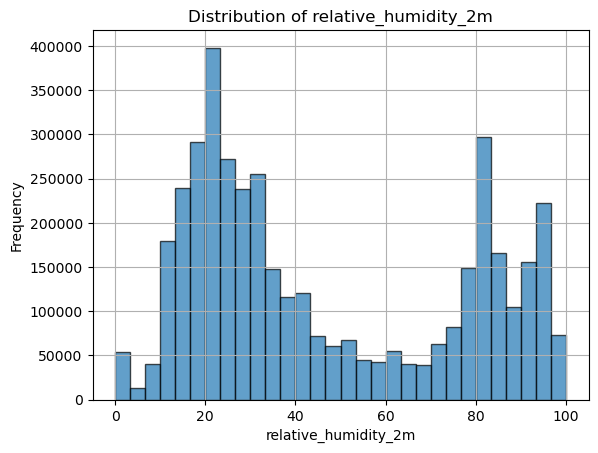

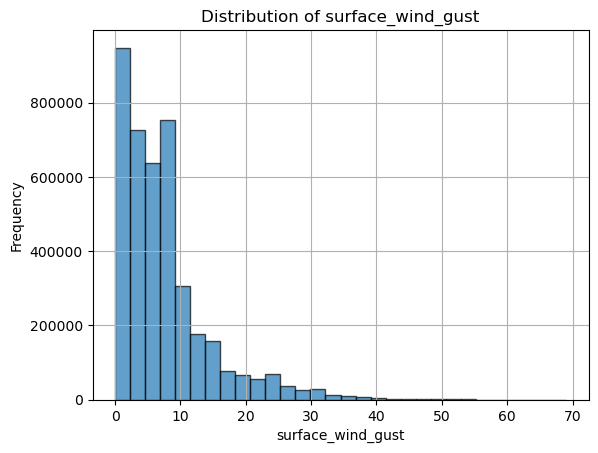

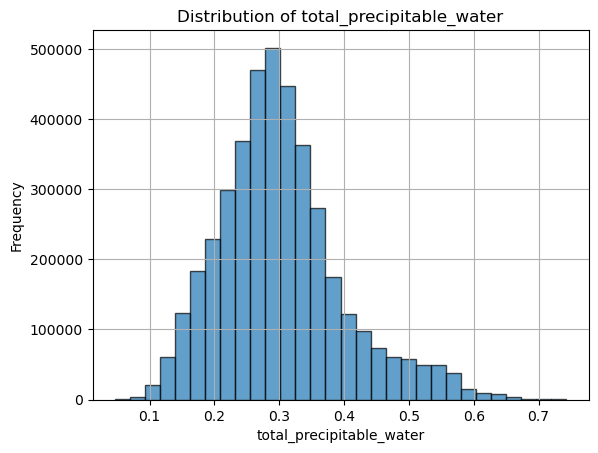

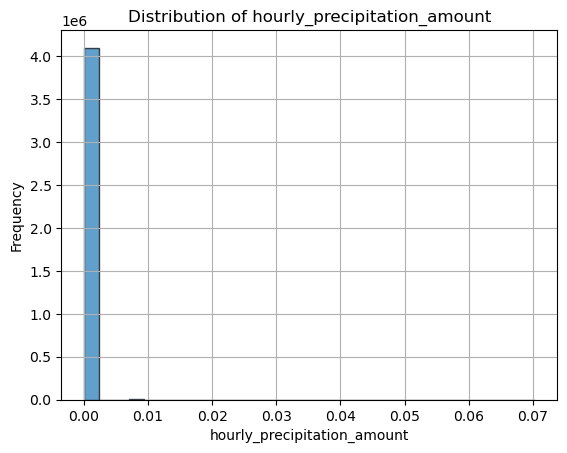

In [7]:
import matplotlib.pyplot as plt

# Select a subset of key columns for visualization
columns_to_plot = [
    'air_temperature_2m', 'relative_humidity_2m', 'surface_wind_gust',
    'total_precipitable_water', 'hourly_precipitation_amount'
]

# Plot histograms for selected columns
for col in columns_to_plot:
    plt.figure()
    df[col].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [13]:
numeric_cols = df.select_dtypes(include=["number"]).columns
print(f"Numeric columns: {numeric_cols}")


Numeric columns: Index(['y', 'x', 'eastward_10m_wind', 'northward_10m_wind',
       'eastward_50m_wind', 'northward_50m_wind', 'eastward_925mb_wind',
       'northward_925mb_wind', 'eastward_850mb_wind', 'northward_850mb_wind',
       'eastward_700mb_wind', 'northward_700mb_wind', 'eastward_500mb_wind',
       'northward_500mb_wind', 'air_temperature_2m', 'dewpoint_depression_2m',
       'large_fire_potential_weather', 'sea_level_pressure',
       'relative_humidity_2m', 'relative_humidity_pbl',
       'relative_humidity_low_trop', 'relative_humidity_mid_trop',
       'total_precipitable_water', 'air_temperature_925mb',
       'air_temperature_850mb', 'air_temperature_700mb',
       'air_temperature_500mb', 'dew_point_temperature', 'low_cloud_fraction',
       'mid_cloud_fraction', 'high_cloud_fraction', 'cape_lifted_at_surface',
       'cape_max_lifted_between_700mb_500mb', 'mucape',
       'lifted_index_from_surface', 'lifted_index_from_850mb',
       'lifted_index_from_700mb', 'lift

In [14]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())       # Fill NaN with mean


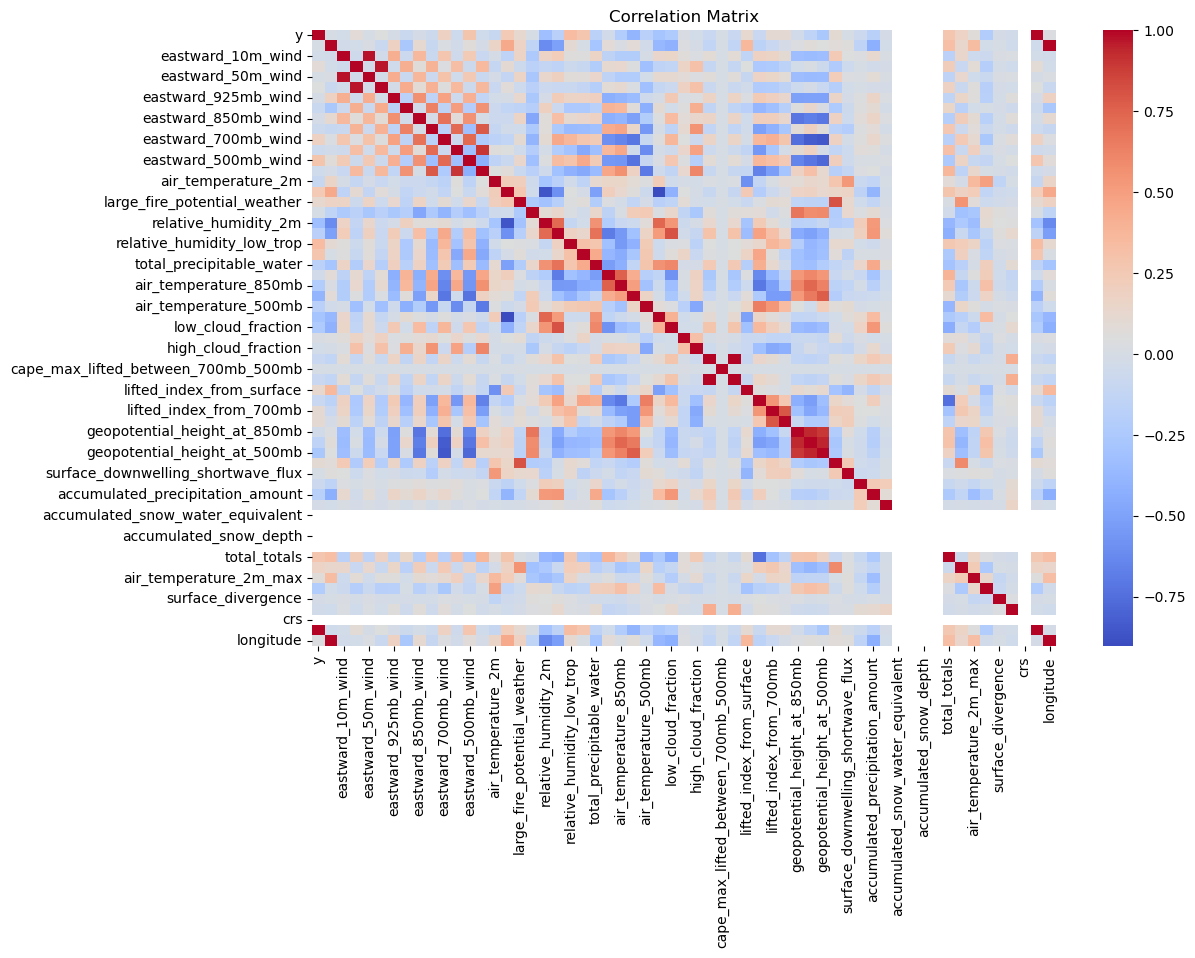

Top correlations with air_temperature_2m:
air_temperature_2m                    1.000000
surface_downwelling_shortwave_flux    0.526165
air_temperature_2m_min                0.494237
air_temperature_2m_max                0.347516
surface_wind_gust                     0.274121
dew_point_temperature                 0.228352
dewpoint_depression_2m                0.212413
large_fire_potential_weather          0.207866
x                                     0.156077
longitude                             0.152952
Name: air_temperature_2m, dtype: float64


In [15]:
correlation_matrix = df[numeric_cols].corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Check correlations with the specific variable
target_variable = 'air_temperature_2m'
correlations = correlation_matrix[target_variable].sort_values(ascending=False)
print(f"Top correlations with {target_variable}:")
print(correlations.head(10))


/Users/shentongli/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


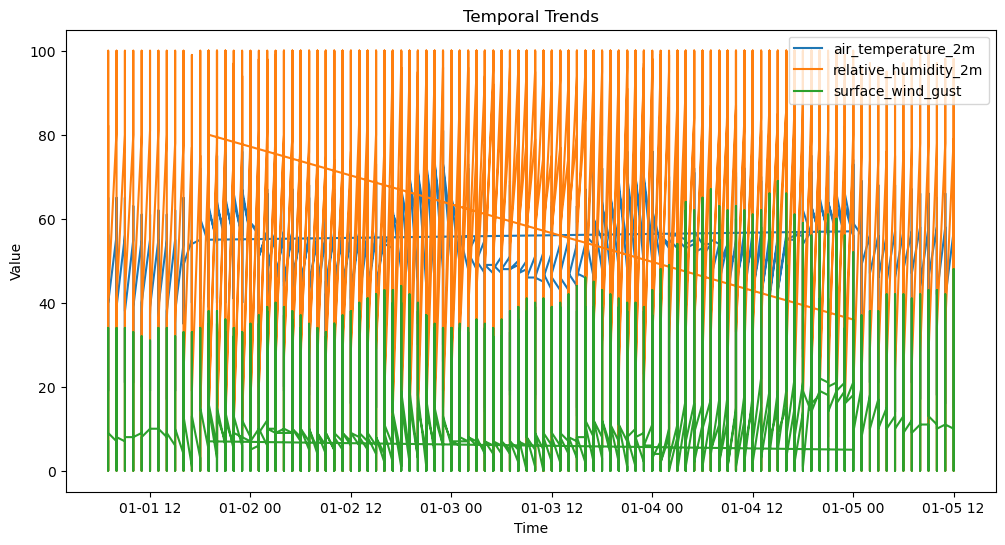

In [12]:
df['time'] = pd.to_datetime(df['time'])
variables_to_plot = [
    'air_temperature_2m', 'relative_humidity_2m', 'surface_wind_gust'
]

plt.figure(figsize=(12, 6))
for var in variables_to_plot:
    plt.plot(df['time'], df[var], label=var)
plt.title('Temporal Trends')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [17]:
print(df[['latitude', 'longitude']].info())  # Check data types and missing values
print(df[['latitude', 'longitude']].head())  # Inspect values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100400 entries, 0 to 4100399
Data columns (total 2 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float32
 1   longitude  float32
dtypes: float32(2)
memory usage: 31.3 MB
None
    latitude   longitude
0  32.141769 -118.695343
1  32.141438 -118.674118
2  32.141094 -118.652893
3  32.140747 -118.631668
4  32.140400 -118.610443


In [18]:
df = df.dropna(subset=['latitude', 'longitude'])  
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')  
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')  
df = df.dropna(subset=['latitude', 'longitude'])  


In [19]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  


<Figure size 1200x800 with 0 Axes>

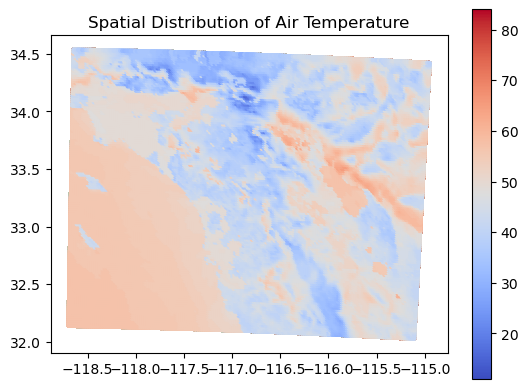

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
gdf.plot(column='air_temperature_2m', cmap='coolwarm', legend=True, markersize=5)
plt.title('Spatial Distribution of Air Temperature')
plt.show()


In [51]:
sd_county_boundary = gpd.read_file('sd_county.shp')
sd_county_boundary.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - California - SPCS - 6
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [43]:
sd_county_boundary = sd_county_boundary[sd_county_boundary.is_valid & ~sd_county_boundary.is_empty]


In [44]:
print(sd_county_boundary.is_valid) 
print(sd_county_boundary.is_empty)  
print(sd_county_boundary.total_bounds)



Series([], dtype: bool)
Series([], dtype: bool)
[nan nan nan nan]


ValueError: aspect must be finite and positive 

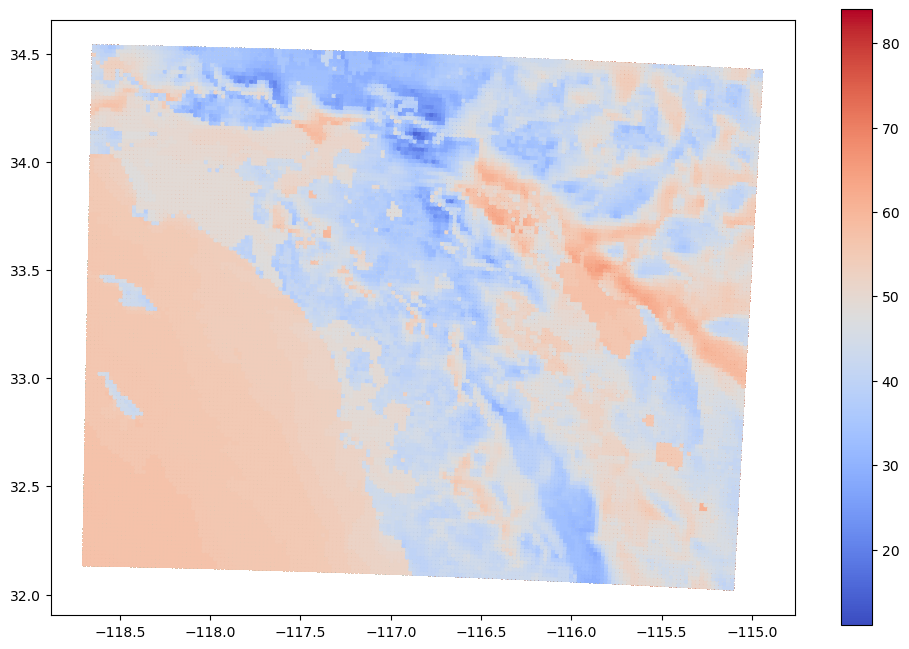

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot air temperature data
gdf.plot(column='air_temperature_2m', cmap='coolwarm', legend=True, markersize=5, ax=ax)

# Plot San Diego County boundary
sd_county_boundary.plot(ax=ax, edgecolor="black", color="none", linewidth=2)

# Add title and labels
plt.title('Spatial Distribution of Air Temperature with San Diego Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()